In [1]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch
from brainseg.image_provider import ImageHandler
from brainseg.provider import provider
from brainseg.streamlit.manager import list_all

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize

sm.set_framework("tf.keras")

2022-06-02 11:37:14.033837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 11:37:14.033863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [2]:
sh = ImageHandler()
provider.register(sh)

In [3]:
seq = iaa.Sequential([
    iaa.Invert(),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rot90([0, 1, 2, 3]),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10),
        shear=(-4, 4),
        cval=255,
    ),
    iaa.Invert(),
])

In [4]:
def preprocess_augment(x, y):
    x = np.asarray(x)
    y = 255 - np.asarray(y)
    
    seg = SegmentationMapsOnImage(y, shape=y.shape)
    x, y = seq(image=x, segmentation_maps=seg)
    y = 255 - y.arr
    x = x / 255.
    y = y / 255.
    # x = resize(x, (320, 320))
    # y = resize(y, (320, 320))
    
    y = y.astype(np.float64)[:, :, :1]
    return x, y

In [5]:
def preprocess(x, y):
    x = np.asarray(x) / 255.
    y = np.asarray(y) / 255.
    # x = resize(x, (320, 320))
    # y = resize(y, (320, 320))
    y = y.astype(np.float64)[:, :, :1]
    # x, y = seq(image=x, segmentation_maps=y)
    return x, y

In [47]:
def preprocess_resize(x, y):
    x = np.asarray(x) / 255.
    y = np.asarray(y) / 255.
    x = resize(x, (320, 320))
    y = resize(y, (320, 320))
    y = y.astype(np.float64)[:, :, :1]
    # x, y = seq(image=x, segmentation_maps=y)
    return x, y

In [26]:
dataset = list_all("/media/nathan/LaCie/Data/whitematter_curated_x16_300/", min_threshold=10)

In [7]:
dataset = list_all("/media/nathan/LaCie/Data/whitematter_curated3/", min_threshold=10)

In [8]:
len(dataset)

1162

In [27]:
s = list([x[1]["data_name"][:14] for x in dataset])

In [29]:
from collections import Counter
Counter(s)

Counter({'M148 LHRH248.c': 47,
         'M148 LHRH236.c': 32,
         'M148 LHRH272.c': 34,
         'M148 LHRH276.c': 35,
         'M148 LHRH264.c': 40,
         'M148 LHRH316.c': 35,
         'M148 LHRH288.c': 36,
         'M148 LHRH284.c': 37,
         'M148 LHRH306.c': 38,
         'M148 LHRH254.c': 29,
         'M148 LHRH266.c': 30,
         'M148 LHRH258.c': 18,
         'M148 LHRH304.c': 30,
         'M148 LHRH302.c': 31,
         'M148 LHRH244.c': 32,
         'M148 LHRH268.c': 28,
         'M148 LHRH240.c': 27,
         'M148 LHRH318.c': 19})

In [30]:
print(len(dataset))

578


In [31]:
train_dataset, test_dataset = train_test_split(dataset, random_state=0)

In [32]:
len(train_dataset)

433

In [33]:
loader = Loader(train_dataset)

In [34]:
x, y = loader[0]

In [35]:
x.size

(300, 300)

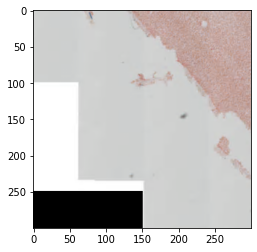

In [36]:
plt.imshow(x)

In [37]:
train_gen = TrainGenerator(Loader(train_dataset), batch_size=4, preprocess=preprocess_augment)
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess)

In [48]:
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess_resize)

In [50]:
model = model = sm.Unet(backbone_name='efficientnetb0', input_shape=(320, 320, 3), classes=1, encoder_weights='imagenet')
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
model.load_weights("/media/nathan/LaCie/Data/models/model_first_x16_300-320_b0_e9_iou0.906.h5")

In [51]:
preds = model.predict(test_gen)

In [ ]:
n = 0

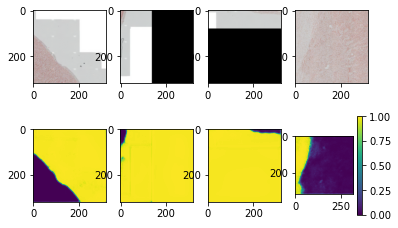

In [63]:
n += 1
b = test_gen[n]
show_batch((b[0], preds[n * 4:(n + 1) * 4]))

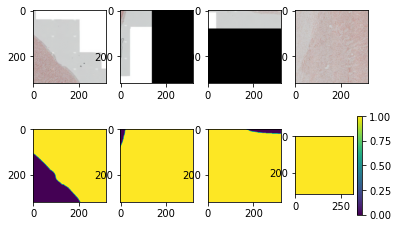

In [64]:
show_batch(b)

In [42]:
n = 2

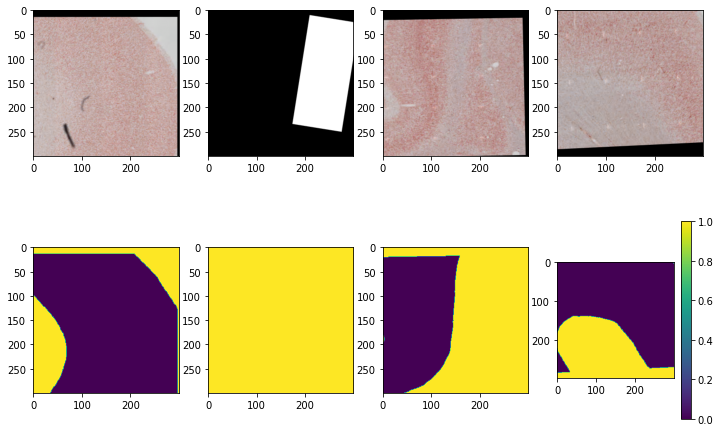

In [46]:
n += 1
plt.figure(figsize=(12, 8))
show_batch(train_gen[n])

In [20]:
model = sm.Unet(backbone_name='efficientnetb0', input_shape=(224, 224, 3), classes=1, encoder_weights='imagenet')
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

2022-06-02 11:37:37.263482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/.cache/pypoetry/virtualenvs/brainseg-XuOkmMtq-py3.8/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-02 11:37:37.263514: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-02 11:37:37.263537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nathan-SBRI): /proc/driver/nvidia/version does not exist


In [21]:
for i in range(10):
    model.fit(train_gen)
    res = model.evaluate(test_gen)
    iou = "{:.3f}".format(res[1])
    model.save_weights(f"/media/nathan/LaCie/Data/models/model_second_x8_224_e{i}_iou{iou}.h5")

2022-06-02 11:37:49.109582: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 57802752 exceeds 10% of free system memory.
2022-06-02 11:37:49.254428: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 57802752 exceeds 10% of free system memory.
2022-06-02 11:37:49.254518: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 57802752 exceeds 10% of free system memory.
2022-06-02 11:37:49.427285: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 72253440 exceeds 10% of free system memory.
2022-06-02 11:37:49.427351: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 72253440 exceeds 10% of free system memory.


73/73 [==============================] - 31s 424ms/step - loss: 0.2585 - iou_score: 0.8705


In [22]:
res = model.evaluate(test_gen)

73/73 [==============================] - 31s 424ms/step - loss: 0.2585 - iou_score: 0.8705


In [23]:
preds = model.predict(test_gen)

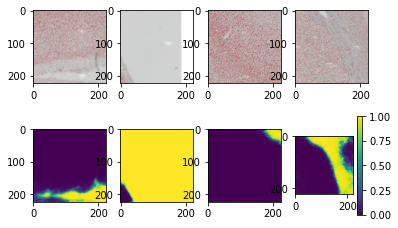

In [24]:
b = test_gen[0]

len(b[0])

show_batch((b[0], preds[:4]))

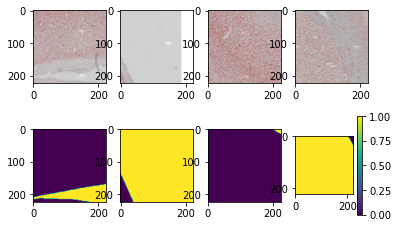

In [25]:
show_batch(b)